In [2614]:
# !pip install tensorflow

In [2641]:
# Imports

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

In [2643]:
csv_files = [f for f in os.listdir(".") if f.endswith(".csv") ]

In [2645]:
final_df = pd.DataFrame()

for csv_file in csv_files:
    df = pd.read_csv(csv_file, nrows=1000)
    final_df = pd.concat([final_df, df])


# these cols are mostly null, dropping
final_df = final_df.drop(["ResourceType", "AntispamDirection", "SuspicionLevel", "ActionGrouped", \
                "Roles", "ActionGranular", "EmailClusterId", "ThreatFamily", "LastVerdict", "MitreTechniques"], axis=1)

final_df = final_df.dropna(subset=['IncidentGrade'])    

final_df['Timestamp'] = pd.to_datetime(final_df['Timestamp'])
final_df = final_df.drop(["Usage"], axis=1)


final_df.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
0,8589935897,44,19153,14081,2024-06-07 01:49:50+00:00,50,36,Exfiltration,BenignPositive,MailMessage,Impacted,98799,138268,360606,160396,441377,15140,425863,453297,153085,192054,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
1,936302875112,135,20224,14666,2024-06-11 14:57:28+00:00,1446,219,CommandAndControl,BenignPositive,Url,Related,98799,138268,360606,42701,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
2,1554778164218,55,33344,51030,2024-06-03 11:22:38+00:00,1,1,InitialAccess,TruePositive,Mailbox,Impacted,98799,138268,360606,160396,31109,24740,31198,35577,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
3,1571958033652,85,318386,290672,2024-06-05 03:38:22+00:00,69,42615,Exfiltration,BenignPositive,Machine,Impacted,98799,138268,360606,160396,441377,673934,425863,453297,9352,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
4,704374641744,1504,45056,362227,2024-06-08 19:46:48+00:00,6,5,InitialAccess,FalsePositive,Mailbox,Impacted,98799,138268,360606,160396,34037,36477,33297,34392,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630


In [2647]:
# removing cols with high cardinality

threshold = round(len(final_df) * 0.20)
print("threshold",threshold)

cardinality = final_df.nunique()

high_cardinality_cols = cardinality[cardinality > threshold].index.tolist()

# altho Timestamp is in high cardinality column, somehow removing it reduces model performance
if "Timestamp" in high_cardinality_cols:
    high_cardinality_cols.remove("Timestamp")

print("dropping these",high_cardinality_cols)

final_df = final_df.drop(high_cardinality_cols, axis=1)

threshold 2388
dropping these ['Id', 'IncidentId', 'AlertId', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName']


In [2649]:
final_df.head()

,OrgId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
0,44,2024-06-07 01:49:50+00:00,50,36,Exfiltration,BenignPositive,MailMessage,Impacted,98799,138268,360606,160396,153085,192054,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
1,135,2024-06-11 14:57:28+00:00,1446,219,CommandAndControl,BenignPositive,Url,Related,98799,138268,360606,42701,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
2,55,2024-06-03 11:22:38+00:00,1,1,InitialAccess,TruePositive,Mailbox,Impacted,98799,138268,360606,160396,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
3,85,2024-06-05 03:38:22+00:00,69,42615,Exfiltration,BenignPositive,Machine,Impacted,98799,138268,360606,160396,9352,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
4,1504,2024-06-08 19:46:48+00:00,6,5,InitialAccess,FalsePositive,Mailbox,Impacted,98799,138268,360606,160396,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630


In [2651]:
# convert from Series to values

df = final_df.copy()
df.reset_index(drop=True, inplace=True)

In [2653]:
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month

# Drop the Timestamp column after extracting features
df.drop(['Timestamp'], axis=1, inplace=True)

In [2655]:
# split OSFamily between 5 and others
df.loc[df["OSFamily"] != 5, 'OSFamily' ] = "others"
df = pd.get_dummies(df, columns=['OSFamily'])

# split osversion between 66 and others
df.loc[df["OSVersion"] != 66, 'OSVersion' ] = "others"
df["OSVersion"].value_counts()
df = pd.get_dummies(df, columns=['OSVersion'])


df.loc[(df["City"] != 10630) & (df["City"] != 0) & (df["City"] != 2), "City"] = "others"
df = pd.get_dummies(df, columns=['City'])


df["State"].value_counts()
df.loc[(df["State"] != 1445), "State"] = "others"
df = pd.get_dummies(df, columns=['State'])

df["CountryCode"].value_counts()
df.loc[(df["CountryCode"] != 242), "CountryCode"] = "others"
df = pd.get_dummies(df, columns=['CountryCode'])

df.loc[(df["ResourceIdName"] != 3586), "ResourceIdName"] = "others"
df = pd.get_dummies(df, columns=['ResourceIdName'])

df.loc[(df["FolderPath"] != 117668), "FolderPath"] = "others"
df = pd.get_dummies(df, columns=['FolderPath'])

df.loc[(df["FileName"] != 289573), "FileName"] = "others"
df = pd.get_dummies(df, columns=['FileName'])



In [2657]:
df.head()

,OrgId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,Hour,DayOfWeek,Month,OSFamily_5,OSFamily_others,OSVersion_66,OSVersion_others,City_0,City_2,City_10630,City_others,State_1445,State_others,CountryCode_242,CountryCode_others,ResourceIdName_3586,ResourceIdName_others,FolderPath_117668,FolderPath_others,FileName_289573,FileName_others
0,44,50,36,Exfiltration,BenignPositive,MailMessage,Impacted,98799,138268,360606,160396,153085,192054,1631,635,860,2251,3421,881,1,4,6,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0
1,135,1446,219,CommandAndControl,BenignPositive,Url,Related,98799,138268,360606,42701,153085,529644,1631,635,860,2251,3421,881,14,1,6,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0
2,55,1,1,InitialAccess,TruePositive,Mailbox,Impacted,98799,138268,360606,160396,153085,529644,1631,635,860,2251,3421,881,11,0,6,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0
3,85,69,42615,Exfiltration,BenignPositive,Machine,Impacted,98799,138268,360606,160396,9352,529644,1631,635,860,2251,3421,881,3,2,6,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0
4,1504,6,5,InitialAccess,FalsePositive,Mailbox,Impacted,98799,138268,360606,160396,153085,529644,1631,635,860,2251,3421,881,19,5,6,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0


In [2659]:
df.columns

# removed
# ['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId', 
# 'AlertTitle', 'IpAddress', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'NetworkMessageId']

Index(['OrgId', 'DetectorId', 'AlertTitle', 'Category', 'IncidentGrade',
       'EntityType', 'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url',
       'DeviceName', 'NetworkMessageId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'Hour', 'DayOfWeek', 'Month', 'OSFamily_5',
       'OSFamily_others', 'OSVersion_66', 'OSVersion_others', 'City_0',
       'City_2', 'City_10630', 'City_others', 'State_1445', 'State_others',
       'CountryCode_242', 'CountryCode_others', 'ResourceIdName_3586',
       'ResourceIdName_others', 'FolderPath_117668', 'FolderPath_others',
       'FileName_289573', 'FileName_others'],
      dtype='object')

In [2661]:
df.loc[(df["OAuthApplicationId"] != 881), "OAuthApplicationId"] = "others"
df.loc[(df["ApplicationName"] != 3421), "ApplicationName"] = "others"
df.loc[(df["ApplicationId"] != 2251), "ApplicationId"] = "others"
df.loc[(df["RegistryValueData"] != 860), "RegistryValueData"] = "others"
df.loc[(df["RegistryValueName"] != 635), "RegistryValueName"] = "others"
df.loc[(df["RegistryKey"] != 1631), "RegistryKey"] = "others"
df.loc[(df["DeviceName"] != 153085), "DeviceName"] = "others"
df.loc[(df["Url"] != 160396), "Url"] = "others"
df.loc[(df["Sha256"] != 138268) & (df["Sha256"] != 0) & (df["Sha256"] != 1), "Sha256"] = "others"
df.loc[(df["DeviceId"] != 98799), "DeviceId"] = "others"
df.loc[(df["IpAddress"] != 360606), "DeviceId"] = "others"
df.loc[(df["NetworkMessageId"] != 529644), "NetworkMessageId"] = "others"


In [2663]:
df = pd.get_dummies(df, columns=["OAuthApplicationId", "ApplicationName", "ApplicationId", "RegistryValueData",\
                                "RegistryValueName", "RegistryKey", "DeviceName", \
                                "Url","Sha256", "DeviceId", "IpAddress", "NetworkMessageId"
                                ])


In [2665]:
# Handle missing values
df.fillna(df.mean(), inplace=True)  # Fill missing numerical values with the mean
df['Category'].fillna('Unknown', inplace=True)  # Fill categorical missing values with 'Unknown'

df['IncidentGrade'] = df['IncidentGrade'].map({'BenignPositive': 0, 'FalsePositive': 1, 'TruePositive': 2})
df['Category'] = pd.Categorical(df['Category']).codes
df['EntityType'] = pd.Categorical(df['EntityType']).codes
df['EvidenceRole'] = pd.Categorical(df['EvidenceRole']).codes

# Checking for duplicate rows and removing them
df = df.drop_duplicates()

/var/folders/lm/x0n0qhz55jq8sbtvvzpkqj2m0000gn/T/ipykernel_51858/3485532390.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.mean(), inplace=True)  # Fill missing numerical values with the mean


In [2667]:
# df["NetworkMessageId"].value_counts()

In [2669]:
df.head()

OrgId  DetectorId  AlertTitle  Category  IncidentGrade  EntityType  \
0     44          50          36         7              0          10   
1    135        1446         219         1              0          19   
2     55           1           1        10              2          11   
3     85          69       42615         7              0           8   
4   1504           6           5        10              1          11   

   EvidenceRole  Hour  DayOfWeek  Month  OSFamily_5  OSFamily_others  \
0             0     1          4      6           1                0   
1             1    14          1      6           1                0   
2             0    11          0      6           1                0   
3             0     3          2      6           1                0   
4             0    19          5      6           1                0   

   OSVersion_66  OSVersion_others  City_0  City_2  City_10630  City_others  \
0             1                 0       0       0           1            0   
1             1                 0       0       0           1            0   
2             1                 0       0       0           1            0   
3             1                 0       0       0           1            0   
4             1                 0       0       0           1            0   

   State_1445  State_others  CountryCode_242  CountryCode_others  \
0           1             0                1                   0   
1           1             0                1                   0   
2           1             0                1                   0   
3           1             0                1                   0   
4           1             0                1                   0   

   ResourceIdName_3586  ResourceIdName_others  FolderPath_117668  \
0                    1                      0                  1   
1                    1                      0                  1   
2                    1                      0                  1   
3                    1                      0                  1   
4                    1                      0                  1   

   FolderPath_others  FileName_289573  FileName_others  \
0                  0                1                0   
1                  0                1                0   
2                  0                1                0   
3                  0                1                0   
4                  0                1                0   

   OAuthApplicationId_881  OAuthApplicationId_others  ApplicationName_3421  \
0                       1                          0                     1   
1                       1                          0                     1   
2                       1                          0                     1   
3                       1                          0                     1   
4                       1                          0                     1   

   ApplicationName_others  ApplicationId_2251  ApplicationId_others  \
0                       0                   1                     0   
1                       0                   1                     0   
2                       0                   1                     0   
3                       0                   1                     0   
4                       0                   1                     0   

   RegistryValueData_860  RegistryValueData_others  RegistryValueName_635  \
0                      1                         0                      1   
1                      1                         0                      1   
2                      1                         0                      1   
3                      1                         0                      1   
4                      1                         0                      1   

   RegistryValueName_others  RegistryKey_1631  RegistryKey_others  \
0                         0                 1                   0  

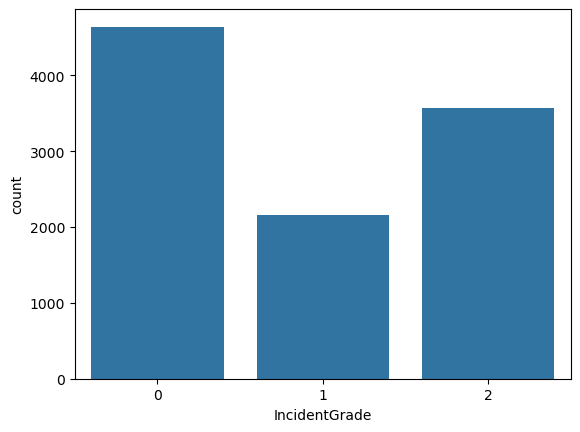

0    4641
2    3563
1    2157
Name: IncidentGrade, dtype: int64


In [2671]:
sns.countplot(x='IncidentGrade', data=df)
plt.show()

# Check the distribution of numerical features
df.describe()

# Checking for class imbalance in IncidentGrade
print(df['IncidentGrade'].value_counts())


In [2631]:
# # Correlation heatmap to check the relationship between features
# plt.figure(figsize=(20, 20))
# sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
# plt.show()

In [2673]:
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [2675]:

# Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = logreg.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))



Logistic Regression Accuracy: 0.5296671490593343
              precision    recall  f1-score   support

           0       0.52      0.77      0.62       893
           1       0.49      0.05      0.09       455
           2       0.56      0.54      0.55       725

    accuracy                           0.53      2073
   macro avg       0.52      0.45      0.42      2073
weighted avg       0.52      0.53      0.48      2073



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [2676]:
# XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_xgb = xgb_model.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8490110950313555
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       893
           1       0.81      0.75      0.78       455
           2       0.89      0.85      0.87       725

    accuracy                           0.85      2073
   macro avg       0.85      0.83      0.84      2073
weighted avg       0.85      0.85      0.85      2073



In [2679]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.7698986975397974
              precision    recall  f1-score   support

           0       0.74      0.86      0.80       893
           1       0.74      0.57      0.65       455
           2       0.84      0.78      0.81       725

    accuracy                           0.77      2073
   macro avg       0.77      0.74      0.75      2073
weighted avg       0.77      0.77      0.77      2073



In [2681]:
# Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_gb = gb_model.predict(X_test)
print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Accuracy: 0.7520501688374337
              precision    recall  f1-score   support

           0       0.68      0.95      0.79       893
           1       0.83      0.50      0.63       455
           2       0.89      0.66      0.76       725

    accuracy                           0.75      2073
   macro avg       0.80      0.71      0.73      2073
weighted avg       0.78      0.75      0.74      2073



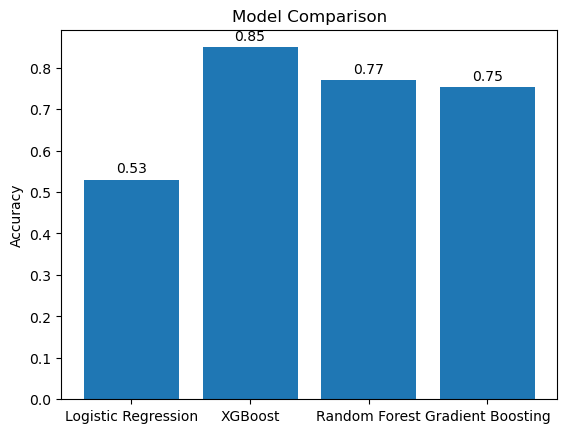

In [2683]:
# Compare model performance
models = ['Logistic Regression', 'XGBoost', 'Random Forest', 'Gradient Boosting']
accuracies = [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_gb)]

plt.bar(models, accuracies)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.2f}', ha='center', va='bottom')

plt.show()

In [ ]:
df.head()

In [2687]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

model.add(Dense(len(np.unique(y)), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))



loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 

y_pred_labels = label_encoder.inverse_transform(y_pred_classes)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5027 - loss: 4.7548 - val_accuracy: 0.5494 - val_loss: 1.1186
Epoch 2/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5701 - loss: 1.2746 - val_accuracy: 0.5745 - val_loss: 0.8932
Epoch 3/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5986 - loss: 0.9368 - val_accuracy: 0.5972 - val_loss: 0.8619
Epoch 4/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6020 - loss: 0.9121 - val_accuracy: 0.6011 - val_loss: 0.8519
Epoch 5/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6179 - loss: 0.8611 - val_accuracy: 0.5953 - val_loss: 0.9500
Epoch 6/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6204 - loss: 0.8320 - val_accuracy: 0.6064 - val_loss: 0.8238
Epoch 7/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6192 - loss: 0.8175 - val_accuracy: 0.6064 - val_loss: 0.8259
Epoch 8/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6344 - loss: 0.7922 - val_accuracy: 0.